Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import defaultdict

Check if GPU is available and set device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define the dataset class with image flipping

In [3]:
class FlippedCIFAR10(CIFAR10):
    def __init__(self, *args, **kwargs):
        # Initialize the superclass
        super(FlippedCIFAR10, self).__init__(*args, **kwargs)

    def __getitem__(self, idx):
        # Get the original image and label
        image, label = super(FlippedCIFAR10, self).__getitem__(idx)

        # Determine if the image should be flipped
        flip = torch.randint(0, 2, (1,), device=device).item()

        # Apply a random vertical flip based on the binary label
        if flip == 1:
            image = transforms.functional.vflip(image)

        # Set the flip label
        flip_label = torch.tensor(flip, device=device)

        # Return the modified image, flip label, and the original label
        return image, flip_label, label

Load CIFAR-10 dataset, create flipped dataset, and split into train and test sets

In [4]:
def prepare_datasets():
    # Define the transformation pipeline for image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image pixel values
    ])

    # Create a flipped version of the CIFAR-10 dataset
    flipped_cifar10 = FlippedCIFAR10(root='./data', train=True, download=True, transform=transform)

    # Determine the sizes for the train and test sets
    train_size = int(0.8 * len(flipped_cifar10))
    test_size = len(flipped_cifar10) - train_size

    # Randomly split the flipped dataset into train and test sets
    train_dataset, test_dataset = random_split(flipped_cifar10, [train_size, test_size])

    # Create DataLoader objects for the train and test sets
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Print the sizes of the training and testing sets
    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Testing set size: {len(test_loader.dataset)}")

    return train_loader, test_loader

CIFAR-10 class names

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Define the model architecture ResNet18 and NeuralNet

In [6]:
# def create_model():
#     # Load a pretrained ResNet-18 model
#     model = torchvision.models.resnet18(pretrained=True)
#     # Replace the fully connected layer with a new one for binary classification
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: flipped or unflipped
#     return model

In [7]:
# Define a function to create a neural network model for binary classification
def create_model():
    # Define a custom neural network class that inherits from nn.Module
    class NeuralNet(nn.Module):
        def __init__(self):
            super(NeuralNet, self).__init__()  # Call the constructor of the superclass
            self.l1 = nn.Linear(3 * 32 * 32, 500)  # Define the first linear layer with input size 3*32*32 and output size 500
            self.relu = nn.ReLU()  # Define the ReLU activation function
            self.l2 = nn.Linear(500, 2)  # Define the second linear layer with input size 500 and output size 2 for binary classification      
        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the input tensor to a 1D tensor
            out = self.l1(x)  # Pass the input through the first linear layer
            out = self.relu(out)  # Apply ReLU activation
            out = self.l2(out)  # Pass the output through the second linear layer
            return out  # Return the final output  
    # Instantiate the NeuralNet class to create the model
    model = NeuralNet()  
    return model  # Return the created model

Train the model

In [8]:
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=2):
    start_time = time.time()
    
    # Set the model to training mode
    model.train()

    # Loop over the specified number of epochs
    for epoch in range(epochs):
        # Initialize variables for running loss and correct predictions
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop over each batch in the train_loader
        for inputs, flip_labels, _ in train_loader:
            # Reset the gradient accumulation
            optimizer.zero_grad()

            # Perform the forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, flip_labels.squeeze())

            # Perform the backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the running loss and count correct predictions
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += flip_labels.size(0)
            correct += (predicted == flip_labels.squeeze()).sum().item()

        # Update the learning rate
        scheduler.step()

        # Calculate the epoch loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        

        # Print the results
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Print a message when training is finished
    elapsed_time = time.time() - start_time
    print(f'Training complete in {elapsed_time // 60}m {elapsed_time % 60}s')
    print('Finished Training')

Evaluate and visualize the model

In [9]:
def evaluate_model(model, test_loader, classes):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to count the number of correct predictions for each class
    class_correct = {i: 0 for i in range(10)}  # Dictionary to store the number of correct predictions for each class
    class_total = {i: 0 for i in range(10)}    # Dictionary to store the total number of samples for each class

    # Disable gradient computation
    with torch.no_grad():
        # Loop over the data loader
        for images, flip_labels, labels in test_loader:
            images, flip_labels, labels = images.to(device), flip_labels.to(device), labels.to(device)
            # Perform the forward pass
            outputs = model(images)

            # Extract the predicted and actual labels
            _, predicted = torch.max(outputs, 1)
            for i in range(flip_labels.size(0)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == flip_labels[i]:
                    class_correct[label] += 1

    # Calculate the accuracy for each class
    for i in range(10):
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy of class {i}: {accuracy:.2f}%')

    # Identify the 3 classes with the lowest accuracy
    lowest_accuracy_classes = sorted(class_correct, key=lambda x: class_correct[x] / class_total[x])[:3]

    print("Top 3 classes with lowest accuracy:")
    for cls in lowest_accuracy_classes:
        accuracy = 100 * class_correct[cls] / class_total[cls]
        print(f"Class {cls}: {accuracy:.2f}%")

    # Collect incorrect samples for visualization
    incorrect_samples = []
    for images, flip_labels, labels in test_loader:
        images, flip_labels, labels = images.to(device), flip_labels.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(flip_labels.size(0)):
            if predicted[i] != flip_labels[i]:
                incorrect_samples.append((images[i], predicted[i], flip_labels[i], labels[i]))

    # Visualize the incorrect samples for the 3 classes with lowest accuracy
    count = 0
    for i, (image, pred, actual, label) in enumerate(incorrect_samples, 1):
        if label.item() in lowest_accuracy_classes and count < 10:
            class_name = classes[label.item()]
            print(f'Incorrect Sample {i}: Predicted: {"1" if pred.item() == 1 else "0"}, Actual: {"1" if actual.item() == 1 else "0"}, Class: {class_name}')
            plt.imshow(transforms.ToPILImage()(image.cpu()))
            plt.axis('off')
            plt.show()
            count += 1

Main function to run the entire process

Files already downloaded and verified
Training set size: 40000
Testing set size: 10000
Epoch 1, Loss: 0.5671, Accuracy: 69.89%
Epoch 2, Loss: 0.5416, Accuracy: 72.05%
Epoch 3, Loss: 0.5312, Accuracy: 73.11%
Epoch 4, Loss: 0.5269, Accuracy: 73.53%
Epoch 5, Loss: 0.5142, Accuracy: 74.22%
Epoch 6, Loss: 0.5119, Accuracy: 74.59%
Epoch 7, Loss: 0.5012, Accuracy: 75.37%
Epoch 8, Loss: 0.4963, Accuracy: 75.61%
Epoch 9, Loss: 0.4936, Accuracy: 75.88%
Epoch 10, Loss: 0.4860, Accuracy: 76.32%
Epoch 11, Loss: 0.4824, Accuracy: 76.72%
Epoch 12, Loss: 0.4791, Accuracy: 76.95%
Epoch 13, Loss: 0.4721, Accuracy: 77.21%
Epoch 14, Loss: 0.4650, Accuracy: 77.97%
Epoch 15, Loss: 0.4650, Accuracy: 77.87%
Epoch 16, Loss: 0.4615, Accuracy: 78.28%
Epoch 17, Loss: 0.4539, Accuracy: 78.88%
Epoch 18, Loss: 0.4494, Accuracy: 79.34%
Epoch 19, Loss: 0.4453, Accuracy: 79.23%
Epoch 20, Loss: 0.4430, Accuracy: 79.45%
Epoch 21, Loss: 0.4352, Accuracy: 79.73%
Epoch 22, Loss: 0.4316, Accuracy: 80.02%
Epoch 23, Loss: 0.42

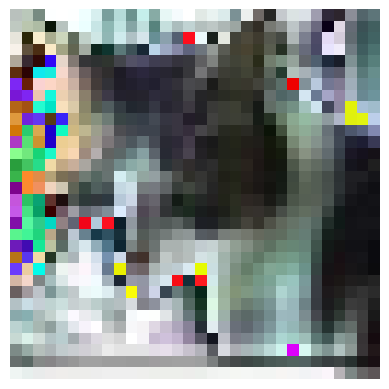

Incorrect Sample 2: Predicted: 0, Actual: 1, Class: frog


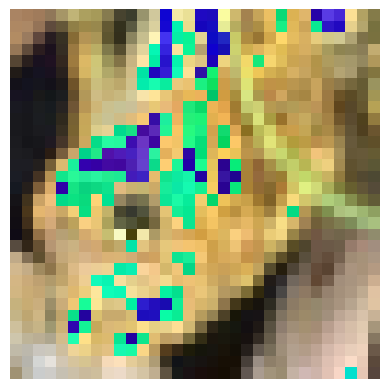

Incorrect Sample 4: Predicted: 1, Actual: 0, Class: dog


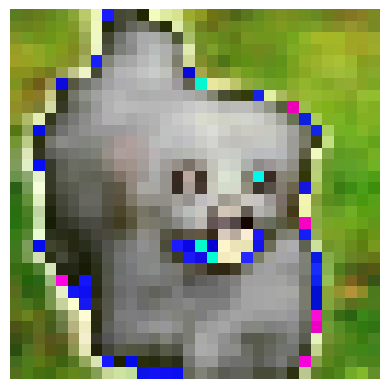

Incorrect Sample 5: Predicted: 0, Actual: 1, Class: dog


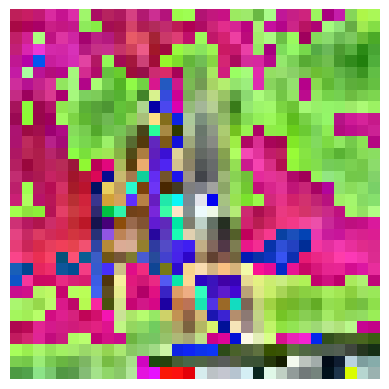

Incorrect Sample 6: Predicted: 0, Actual: 1, Class: cat


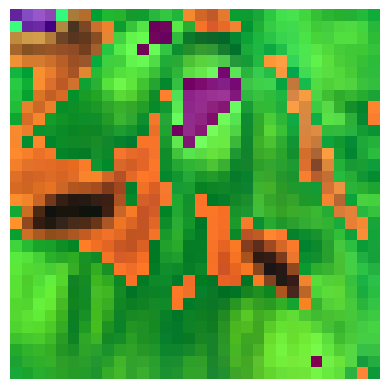

Incorrect Sample 10: Predicted: 0, Actual: 1, Class: cat


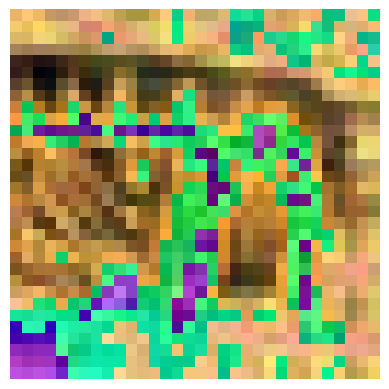

Incorrect Sample 17: Predicted: 1, Actual: 0, Class: dog


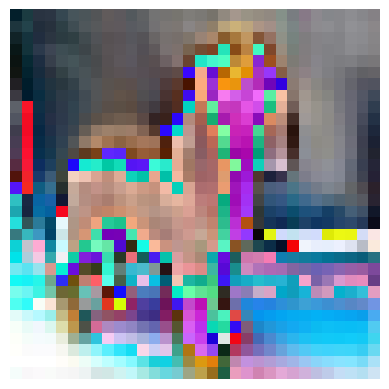

Incorrect Sample 18: Predicted: 0, Actual: 1, Class: dog


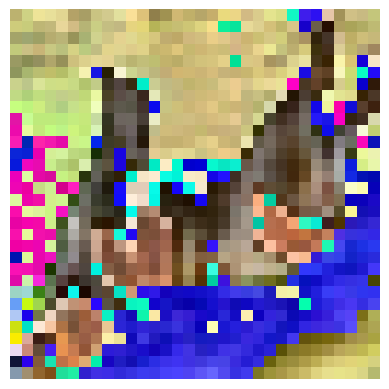

Incorrect Sample 20: Predicted: 0, Actual: 1, Class: dog


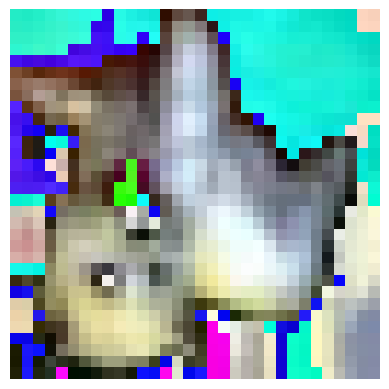

Incorrect Sample 25: Predicted: 0, Actual: 1, Class: frog


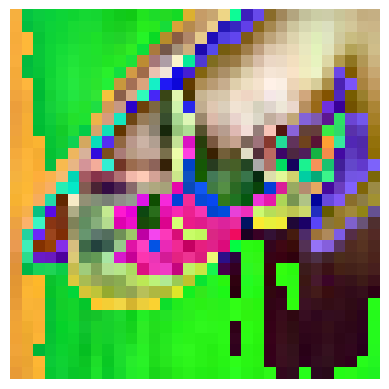

In [13]:
def main():
    # Initialize data loaders
    train_loader, test_loader = prepare_datasets()

    # Create the model
    model = create_model()

    # Initialize the loss function, optimizer, and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=24, gamma=0.1)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, scheduler, epochs=24)

    # Evaluate the model on the test dataset
    evaluate_model(model, test_loader, classes)

if __name__ == "__main__":
    main()